# Intro


#### This is a *work in progress*. Please <span style='color:#0a0'>upvote</span> the kernel to keep this going.

I have tried several public notebooks to find the best way for ensemble. Until now, this was the best outcome.

- The first notebook: https://www.kaggle.com/thebigd8ta/higher-lb-score-by-tuning-mloss-upgrade-1696e2
- The second notebook: https://www.kaggle.com/zhangxianjue/train-age?scriptVersionId=43259472

Note1: It is important to blend the best of each notebook. So I selected the best version of each notebook.

Note2: I will not be upgrading the code until the end of competition.


## Ensemble learning

Ensemble learning is the process by which multiple models, such as classifiers or experts, are strategically generated and combined to solve a particular computational intelligence problem. Ensemble learning is primarily used to improve the (classification, prediction, function approximation, etc.)

he motivation for using ensemble models is to reduce the generalization error of the prediction. As long as the base models are diverse and independent, the prediction error of the model decreases when the ensemble approach is used. The approach seeks the wisdom of crowds in making a prediction. Even though the ensemble model has multiple base models within the model, it acts and performs as a single model. Most of the practical data mining solutions utilize ensemble modeling techniques. 

![ens](https://cdn-images-1.medium.com/max/1000/0*sOtXk_8ZftGGU00_.png)

# Notebook 1

https://www.kaggle.com/thebigd8ta/higher-lb-score-by-tuning-mloss-upgrade-1696e2

In [106]:
#!pip install /home/jacoblamkey/Downloads/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
#!pip install /home/jacoblamkey/Downloads/efficientnet/efficientnet-1.1.0/ -f ./ --no-index


In [3]:
import os
#import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image

In [4]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [5]:
seed_everything(42)

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
#BATCH_SIZE = BATCH_SIZE*strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


## 2.1. Commit now <a class="anchor" id="2.1"></a>

[Back to Table of Contents](#0.1)

In [7]:
Dropout_model = 0.3856
FVC_weight = 0.2
Confidence_weight = 0.2

## 3. Download data, auxiliary functions and model tuning <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [8]:
train = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/train.csv') 

In [9]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [10]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/home/jacoblamkey/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [11]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [12]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [19]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(Dropout_model)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    weights = [w for w in os.listdir('/home/jacoblamkey/Downloads/osic-model-weights') if model_class in w][0]
    model.load_weights('/home/jacoblamkey/Downloads/osic-model-weights/' + weights)
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
with strategy.scope():
    models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

ModuleNotFoundError: No module named 'efficientnet.tfkeras'

In [118]:
tr_p, vl_p = train_test_split(P, shuffle=True, train_size = 0.9) 

In [119]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 69) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [120]:
subs = []
for model in models:
    metric = []
    for q in tqdm(range(1, 10)):
        m = []
        for p in vl_p:
            x = [] 
            tab = [] 

            if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue

            ldir = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                    x.append(get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{p}/{i}')) 
                    tab.append(get_tab(train.loc[train.Patient == p, :])) 
            if len(x) < 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q / 10)

            percent_true = train.Percent.values[train.Patient == p]
            fvc_true = train.FVC.values[train.Patient == p]
            weeks_true = train.Weeks.values[train.Patient == p]

            fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
            percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
            m.append(score(fvc_true, fvc, percent))
        print(np.mean(m))
        metric.append(np.mean(m))

    q = (np.argmin(metric) + 1)/ 10

    sub = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/sample_submission.csv') 
    test = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

6.814128338064982
6.814125836771655
6.814117087408743
6.814105526793441
6.814098527800782
6.814074326512993
6.814046163160725
6.814012621137156
6.814025357869171



## 4. Prediction and submission <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

## 4.1 Average prediction <a class="anchor" id="4.1"></a>

[Back to Table of Contents](#0.1)

In [121]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [122]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3092.863664,143.050520
1,ID00421637202311550012437_-12,2847.459621,190.504912
2,ID00422637202311677017371_-12,2002.654819,149.327313
3,ID00423637202312137826377_-12,3410.692459,195.951362
4,ID00426637202313170790466_-12,2971.430485,118.255453


In [123]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

In [124]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

## 4.2 Osic-Multiple-Quantile-Regression <a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [125]:
ROOT = "/home/jacoblamkey/Documents/Data/.kaggle"
BATCH_SIZE=128*strategy.num_replicas_in_sync

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [126]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [127]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [128]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [129]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [130]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [131]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [132]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [133]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [134]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

## 4.3 The change of mloss <a class="anchor" id="4.3"></a>

[Back to Table of Contents](#0.1)

In [135]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [136]:
y = tr['FVC'].values.astype(np.float32)
z = tr[FE].values.astype(np.float32)
ze = sub[FE].values.astype(np.float32)
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [140]:
with strategy.scope():
    net = make_model(nh)
    
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [141]:
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

In [142]:
%%time
cnt = 0
EPOCHS = 855
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [34.469669342041016, 6.508659362792969]
val [39.76385498046875, 6.867187023162842]
predict val...
predict test...
FOLD 2
train [34.077152252197266, 6.518935203552246]
val [45.27122116088867, 7.126177787780762]
predict val...
predict test...
FOLD 3
train [32.43731689453125, 6.45019006729126]
val [45.84264373779297, 6.680820941925049]
predict val...
predict test...
FOLD 4
train [33.40378189086914, 6.4816155433654785]
val [34.321815490722656, 6.538095474243164]
predict val...
predict test...
FOLD 5
train [33.36246109008789, 6.499128818511963]
val [43.117977142333984, 6.776651382446289]
predict val...
predict test...
CPU times: user 3min 37s, sys: 22.6 s, total: 4min
Wall time: 2min 45s


In [143]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

144.87577329753665 234.2265004310235


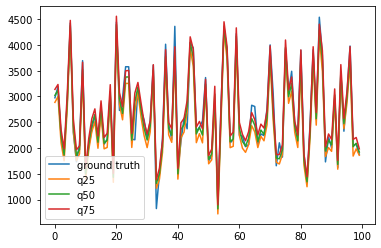

In [144]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [145]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

78.26806640625 234.2265004310235 401.40625 1.0


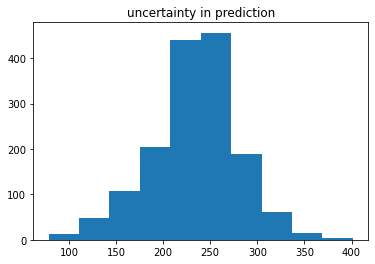

In [146]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [147]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [148]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2895.114441,238.098572
1541,ID00419637202311204720264_-11,3020,100.0,2892.466248,239.112122
1542,ID00419637202311204720264_-10,3020,100.0,2889.817932,240.125366
1543,ID00419637202311204720264_-9,3020,100.0,2887.169922,241.138672
1544,ID00419637202311204720264_-8,3020,100.0,2884.521729,242.152161
1545,ID00419637202311204720264_-7,3020,100.0,2881.873535,243.165405
1546,ID00419637202311204720264_-6,3020,100.0,2879.225403,244.178772
1547,ID00419637202311204720264_-5,3020,100.0,2876.577209,245.191956
1548,ID00419637202311204720264_-4,3020,100.0,2873.929138,246.205505
1549,ID00419637202311204720264_-3,3020,100.0,2871.280823,247.218628


In [149]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [150]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2895.114441,238.098572,2895.114441,238.098572
1541,ID00419637202311204720264_-11,2892.466248,239.112122,2892.466248,239.112122
1542,ID00419637202311204720264_-10,2889.817932,240.125366,2889.817932,240.125366
1543,ID00419637202311204720264_-9,2887.169922,241.138672,2887.169922,241.138672
1544,ID00419637202311204720264_-8,2884.521729,242.152161,2884.521729,242.152161


In [151]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2660.687984,325.125679,2011.629456,2589.733238,2702.894470,2841.698883,3231.202209
Confidence,730.0,283.996902,45.782395,188.673187,247.289467,284.365784,321.271553,374.551941
FVC1,730.0,2660.687984,325.125679,2011.629456,2589.733238,2702.894470,2841.698883,3231.202209
Confidence1,730.0,283.996902,45.782395,188.673187,247.289467,284.365784,321.271553,374.551941


In [152]:
otest = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [153]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [154]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

## 4.4 Ensemble and blending <a class="anchor" id="4.4"></a>

[Back to Table of Contents](#0.1)

In [155]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [156]:
df = df1[['Patient_Week']].copy()
df['FVC'] = FVC_weight*df1['FVC'] + (1-FVC_weight)*df2['FVC']
df['Confidence'] = Confidence_weight*df1['Confidence'] + (1-Confidence_weight)*df2['Confidence']
df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2902.454772,219.100980
1,ID00419637202311204720264_-10,2928.807886,219.091204
2,ID00419637202311204720264_-11,2931.736135,219.090205
3,ID00419637202311204720264_-12,2934.664286,219.088961
4,ID00419637202311204720264_-2,2905.382874,219.099786


In [157]:
df.to_csv('/home/jacoblamkey/Documents/Data/.kaggle/submission.csv', index=False)

In [158]:
df_issa1 = df.copy()

# 2. Second notebook

https://www.kaggle.com/zhangxianjue/train-age



In [71]:
Dropout_model = 0.3856
FVC_weight = 0.2
Confidence_weight = 0
#!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
#!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

In [72]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
train = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/train.csv') 

In [73]:
tr_age_max = train.Age.values.max()
tr_age_min = train.Age.values.min()
tr_age_mean = train.Age.values.mean()

In [74]:
def expandFVC_Percent(DS):
    DS['FVC_Percent'] = DS['FVC'] / DS['Percent']
    return DS

In [75]:
def expandFE(data_set):
    data_set['MinWeeks'] = data_set.groupby('Patient')['Weeks'].transform('min')
    sub_tr = data_set.loc[data_set['Weeks']==data_set['MinWeeks']]

    sub_tr['MinFVC'] = sub_tr['FVC']

    sub_tr = sub_tr[['Patient', 'MinFVC']]

    merged = data_set.merge(sub_tr, on='Patient', how='outer')


    data_set=merged
    
    data_set['MinFVC'] = (data_set['MinFVC'] - data_set['MinFVC'].min())/(data_set['MinFVC'].max()-data_set['MinFVC'].min())
    print(data_set.sample(5))
    return data_set

In [76]:
train = expandFE(train)
# train = expandFVC_Percent(train)

                        Patient  Weeks   FVC    Percent  Age     Sex  \
527   ID00128637202219474716089     36  2274  99.283968   87  Female   
1140  ID00296637202279895784347     32  2210  65.617577   58    Male   
168   ID00048637202185016727717      9  1477  64.514720   70  Female   
135   ID00035637202182204917484     14  2634  72.006561   69    Male   
785   ID00199637202248141386743      5  2672  64.728682   62    Male   

     SmokingStatus  MinWeeks    MinFVC  
527   Never smoked        34  0.223811  
1140     Ex-smoker         5  0.224368  
168   Never smoked         9  0.066865  
135      Ex-smoker        11  0.318165  
785      Ex-smoker         5  0.307764  


/home/jacoblamkey/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [77]:
print(train.head())
print(train.sample(10))

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   MinWeeks    MinFVC  
0        -4  0.241456  
1        -4  0.241456  
2        -4  0.241456  
3        -4  0.241456  
4        -4  0.241456  
                        Patient  Weeks   FVC     Percent  Age     Sex  \
1521  ID00407637202308788732304     75  2963   87.393818   66    Male   
357   ID00093637202205278167493     39  3841   88.315092   69    Male   
603   ID00136637202224951350618     43  3362   96.776051   64    Male   
897   ID00224637202259281193413      9  2679   57.312168   72    Male   
214 

In [78]:
def get_tab(df):
    # df: data frame
    # [age, male/female[0/1], SmokingStatus[00/11/01], BaseFvc] (5,)
    vector = [(df.Age.values[0] - tr_age_min) / (tr_age_max-tr_age_min)] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    vector.extend([df['MinFVC'].values[0]])
#     vector.extend([df['FVC_Percent'].values[0]])
    return np.array(vector) 

In [79]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

/home/jacoblamkey/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [80]:
from tensorflow.keras.utils import Sequence
import math

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=8):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}  # imgs for each person; self.trian_data[pi] = [img1, img2, ..., imgn]
        for p in train.Patient.values:
            # filenames in "~/train/personid/"
            self.train_data[p] = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{p}/')
    
    def __len__(self):
#         return 1000
        return math.ceil(len(self.keys) / float(self.batch_size)) 
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)  # persons in batch size
        for k in keys:
            #  chose a {[img, tab], a}for each person (only 1 img)
            try:
                self.train_data[k].sort()
                mx_len = len(self.train_data[k])
                i = np.random.choice(self.train_data[k][mx_len//3:mx_len//3*2], size=1)[0]
#                 i = self.train_data[k][max_len//2]
                img = get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x, a, tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [81]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
#     inp2 = Input(shape=(4,))  # original is 4
    inp2 = Input(shape=(5,))  # add the feature of MinFVC
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(Dropout_model)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
#     weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
#     model.load_weights('../input/osic-model-weights/' + weights)
    return model

In [82]:
model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
with strategy.scope():
    models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
    
print('Number of models: ' + str(len(models)))

model = models[0]

# model = get_model()

Number of models: 1


In [83]:
# efn_path = "../input/trainefn/efn.ckpt"
# model.load_weights(efn_path)

In [84]:
model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')  # original is lr=0.001

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, 16, 16, 2048) 28512656    input_21[0][0]                   
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           efficientnet-b5[0][0]            
_______________________________________________________________________________________

In [85]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)
subs = []
q = -1

In [90]:
q = -1
# with open('../input/trainefn/q.txt', 'r') as f:
#     q=float(f.readlines()[0].strip())
print(q)

1


In [91]:
sub = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/sample_submission.csv') 
test = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv') 
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 

In [92]:
test = expandFE(test)
# test = expandFVC_Percent(test)

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked   
3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker   
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker   
2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker   
1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker   

   MinWeeks    MinFVC  
4         0  0.729472  
3        17  1.000000  
0         6  0.799120  
2         6  0.000000  
1        15  0.593109  


In [93]:
for p in test.Patient.unique():
    x = [] 
    tab = [] 
    ldir = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/')
    for i in ldir:
        if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
            x.append(get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/{i}')) 
            tab.append(get_tab(test.loc[test.Patient == p, :])) 
    if len(x) <= 1:
        continue
    tab = np.array(tab) 

    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]


for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 

    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 

_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
subs.append(_sub)
print(subs)

[                      Patient_Week          FVC  Confidence
0    ID00419637202311204720264_-12  3021.919500   72.106355
1    ID00421637202311550012437_-12  2741.555224   84.600515
2    ID00422637202311677017371_-12  1931.374388   78.046881
3    ID00423637202312137826377_-12  3297.289115   82.548018
4    ID00426637202313170790466_-12  2925.697315   72.522283
..                             ...          ...         ...
725  ID00419637202311204720264_133  3006.456862   83.729993
726  ID00421637202311550012437_133  2727.832727   93.212564
727  ID00422637202311677017371_133  1920.302932   86.369562
728  ID00423637202312137826377_133  3280.843540   92.415363
729  ID00426637202313170790466_133  2917.271427   79.553541

[730 rows x 3 columns]]


In [94]:
N = len(subs)
print(N)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
print(img_sub.sample(5))

1
                      Patient_Week          FVC  Confidence
662  ID00422637202311677017371_120  1921.295545   85.376948
647  ID00422637202311677017371_117  1921.524610   85.147884
246   ID00421637202311550012437_37  2736.917966   84.127325
269   ID00426637202313170790466_41  2922.617508   74.207460
317   ID00422637202311677017371_51  1926.564031   80.108462


In [19]:

from efficientnet_pytorch_3d import EfficientNet3D
import torch

model = EfficientNet3D.from_name("efficientnet-b5", override_params={'num_classes': 3}, in_channels=9)

from torchsummary import summary
summary(model, input_size=(512, 512, 1))

model = model.cuda()
inputs = torch.randn(((5,))).cuda()
labels = torch.tensor(512, 512, 1).cuda()
# test forward
num_classes = 3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.train()
for epoch in range(2):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    print('[%d] loss: %.3f' % (epoch + 1, loss.item()))

print('Finished Training')

RuntimeError: Expected 5-dimensional input for 5-dimensional weight [48, 1, 3, 3, 3], but got 4-dimensional input of size [2, 513, 513, 2] instead

In [95]:
ROOT = "/home/jacoblamkey/Documents/Data/.kaggle"
BATCH_SIZE=128*strategy.num_replicas_in_sync

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

add infos
(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [96]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
data['FVC_Percent'] = data['FVC'] / data['Percent']
# FE += ['age','percent','week','BASE', 'FVC_Percent']
FE += ['age','percent','week','BASE']
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss


def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model
print(FE)

['Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes', 'age', 'percent', 'week', 'BASE']


In [97]:
y = tr['FVC'].values  # train target
z = tr[FE].values  # fetures (1535, 9)
print(z.shape)
ze = sub[FE].values  # fetures of submission (730, 9) e: estimate
print(ze.shape) 
nh = z.shape[1] 
print(nh)  # feature numbers (9,)
pe = np.zeros((ze.shape[0], 3))  #estimate of prediction
pred = np.zeros((z.shape[0], 3))  # prediction of truth ground
with strategy.scope():    
    net = make_model(nh)
print(net.summary())
print(net.count_params())
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

(1535, 9)
(730, 9)
9
Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
___________________________________________________________________________

In [98]:
cnt = 0
EPOCHS = 800
y = y.astype(np.float32)
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [34.47637176513672, 6.513923645019531]
val [39.85040283203125, 6.86565637588501]
predict val...
predict test...
FOLD 2
train [34.06155776977539, 6.523756504058838]
val [45.42940902709961, 7.124200820922852]
predict val...
predict test...
FOLD 3
train [32.638267517089844, 6.452246189117432]
val [46.845672607421875, 6.67275333404541]
predict val...
predict test...
FOLD 4
train [33.55527877807617, 6.483666896820068]
val [34.03110885620117, 6.528132438659668]
predict val...
predict test...
FOLD 5
train [33.570655822753906, 6.49782657623291]
val [42.6612434387207, 6.763314247131348]
predict val...
predict test...


145.08138479425386 233.7395183351995


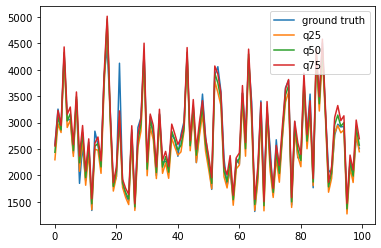

78.295166015625 233.7395183351995 386.01806640625 1.0


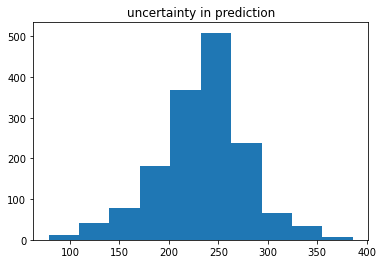

In [99]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()
sub.head()
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']
subm.head()
subm.describe().T
otest = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df = df1[['Patient_Week']].copy()
df['FVC'] = FVC_weight*df1['FVC'] + (1-FVC_weight)*df2['FVC']
df['Confidence'] = Confidence_weight*df1['Confidence'] + (1-Confidence_weight)*df2['Confidence']
df.head();
df.to_csv('submission.csv', index=False)

In [100]:
df_issa2 = df.copy()

notebook3

                        Patient  Weeks   FVC     Percent  Age     Sex  \
1085  ID00283637202278714365037      7  1967   54.578246   60    Male   
1080  ID00279637202272164826258     46  4046   88.852776   70    Male   
1162  ID00305637202281772703145     12  2776   73.392555   62    Male   
1037  ID00264637202270643353440     19  2239  132.453857   76  Female   
171   ID00048637202185016727717     11  1399   61.107714   70  Female   

     SmokingStatus  MinWeeks    MinFVC  
1085  Never smoked         0  0.176449  
1080     Ex-smoker         8  0.580609  
1162     Ex-smoker         8  0.365713  
1037  Never smoked        13  0.171434  
171   Never smoked         9  0.085810  
                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-s

/home/jacoblamkey/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/jacoblamkey/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Number of models: 1
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, 16, 16, 2048) 28512656    input_36[0][0]                   
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 2048)         0           efficientnet-b5[0][0]            
__________________________________________________________________

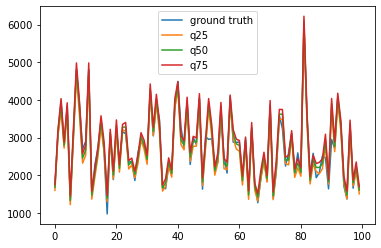

-16.052978515625 232.3256051029367 416.615234375 0.9973941368078176


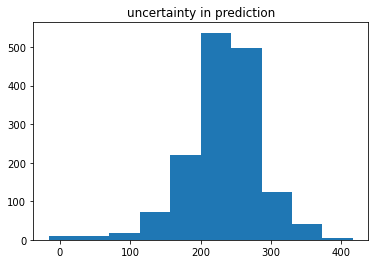

In [102]:
Dropout_model = 0.3856
FVC_weight = 0.2
Confidence_weight = 0
#!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
#!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(45)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
train = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/train.csv') 

tr_age_max = train.Age.values.max()
tr_age_min = train.Age.values.min()
tr_age_mean = train.Age.values.mean()

def expandFVC_Percent(DS):
    DS['FVC_Percent'] = DS['FVC'] / DS['Percent']
    return DS

def expandFE(data_set):
    data_set['MinWeeks'] = data_set.groupby('Patient')['Weeks'].transform('min')
    sub_tr = data_set.loc[data_set['Weeks']==data_set['MinWeeks']]

    sub_tr['MinFVC'] = sub_tr['FVC']

    sub_tr = sub_tr[['Patient', 'MinFVC']]

    merged = data_set.merge(sub_tr, on='Patient', how='outer')


    data_set=merged
    
    data_set['MinFVC'] = (data_set['MinFVC'] - data_set['MinFVC'].min())/(data_set['MinFVC'].max()-data_set['MinFVC'].min())
    print(data_set.sample(5))
    return data_set

train = expandFE(train)
# train = expandFVC_Percent(train)

print(train.head())
print(train.sample(10))

def get_tab(df):
    # df: data frame
    # [age, male/female[0/1], SmokingStatus[00/11/01], BaseFvc] (5,)
    vector = [(df.Age.values[0] - tr_age_min) / (tr_age_max-tr_age_min)] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    vector.extend([df['MinFVC'].values[0]])
#     vector.extend([df['FVC_Percent'].values[0]])
    return np.array(vector) 

A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

from tensorflow.keras.utils import Sequence
import math

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=8):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}  # imgs for each person; self.trian_data[pi] = [img1, img2, ..., imgn]
        for p in train.Patient.values:
            # filenames in "~/train/personid/"
            self.train_data[p] = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{p}/')
    
    def __len__(self):
#         return 1000
        return math.ceil(len(self.keys) / float(self.batch_size)) 
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)  # persons in batch size
        for k in keys:
            #  chose a {[img, tab], a}for each person (only 1 img)
            try:
                self.train_data[k].sort()
                mx_len = len(self.train_data[k])
                i = np.random.choice(self.train_data[k][mx_len//3:mx_len//3*2], size=1)[0]
#                 i = self.train_data[k][max_len//2]
                img = get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x, a, tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
#     inp2 = Input(shape=(4,))  # original is 4
    inp2 = Input(shape=(5,))  # add the feature of MinFVC
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(Dropout_model)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
#     weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
#     model.load_weights('../input/osic-model-weights/' + weights)
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
with strategy.scope():
    models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
    
print('Number of models: ' + str(len(models)))

model = models[0]

# model = get_model()

# efn_path = "../input/trainefn/efn.ckpt"
# model.load_weights(efn_path)

model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')  # original is lr=0.001

def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)
subs = []
q = -1

q = -1
# with open('../input/trainefn/q.txt', 'r') as f:
#     q=float(f.readlines()[0].strip())
print(q)

sub = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/sample_submission.csv') 
test = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv') 
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 

test = expandFE(test)
# test = expandFVC_Percent(test)

for p in test.Patient.unique():
    x = [] 
    tab = [] 
    ldir = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/')
    for i in ldir:
        if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
            x.append(get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/{i}')) 
            tab.append(get_tab(test.loc[test.Patient == p, :])) 
    if len(x) <= 1:
        continue
    tab = np.array(tab) 

    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]


for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 

    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 

_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
subs.append(_sub)
print(subs)

N = len(subs)
print(N)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
print(img_sub.sample(5))

ROOT = "/home/jacoblamkey/Documents/Data/.kaggle"
BATCH_SIZE=128*strategy.num_replicas_in_sync

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
data['FVC_Percent'] = data['FVC'] / data['Percent']
# FE += ['age','percent','week','BASE', 'FVC_Percent']
FE += ['age','percent','week','BASE']
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss


def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model
print(FE)

y = tr['FVC'].values  # train target
z = tr[FE].values  # fetures (1535, 9)
print(z.shape)
ze = sub[FE].values  # fetures of submission (730, 9) e: estimate
print(ze.shape) 
nh = z.shape[1] 
print(nh)  # feature numbers (9,)
pe = np.zeros((ze.shape[0], 3))  #estimate of prediction
pred = np.zeros((z.shape[0], 3))  # prediction of truth ground
with strategy.scope():    
    net = make_model(nh)
print(net.summary())
print(net.count_params())
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

cnt = 0
EPOCHS = 800
y = y.astype(np.float32)
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()
sub.head()
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']
subm.head()
subm.describe().T
otest = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df = df1[['Patient_Week']].copy()
df['FVC'] = FVC_weight*df1['FVC'] + (1-FVC_weight)*df2['FVC']
df['Confidence'] = Confidence_weight*df1['Confidence'] + (1-Confidence_weight)*df2['Confidence']
df.head();
df.to_csv('submission.csv', index=False)

df_issa3 = df.copy()



Notebook4

                        Patient  Weeks   FVC     Percent  Age     Sex  \
547   ID00130637202220059448013     24  1436   59.353559   65  Female   
1387  ID00367637202296290303449     87   837   34.160477   57  Female   
500   ID00125637202218590429387     14  2320   53.094105   65    Male   
984   ID00241637202264294508775      6  1349   76.077149   66  Female   
1295  ID00341637202287410878488     36  2854  143.633619   68  Female   

         SmokingStatus  MinWeeks    MinFVC  
547       Never smoked        11  0.125371  
1387      Never smoked        35  0.065193  
500       Never smoked         8  0.247771  
984       Never smoked         2  0.071322  
1295  Currently smokes        28  0.340639  
                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.86

/home/jacoblamkey/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/jacoblamkey/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Number of models: 1
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, 16, 16, 2048) 28512656    input_46[0][0]                   
__________________________________________________________________________________________________
input_55 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 2048)         0           efficientnet-b5[0][0]            
__________________________________________________________________

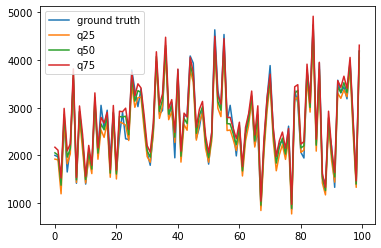

86.29150390625 242.3483353108459 480.429443359375 1.0


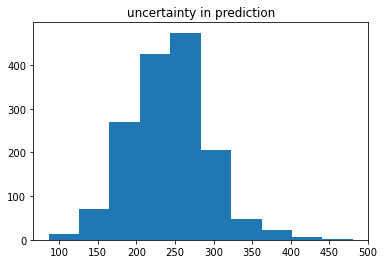

In [103]:
Dropout_model = 0.3856
FVC_weight = 0.2
Confidence_weight = 0
#!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
#!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(43)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
train = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/train.csv') 

tr_age_max = train.Age.values.max()
tr_age_min = train.Age.values.min()
tr_age_mean = train.Age.values.mean()

def expandFVC_Percent(DS):
    DS['FVC_Percent'] = DS['FVC'] / DS['Percent']
    return DS

def expandFE(data_set):
    data_set['MinWeeks'] = data_set.groupby('Patient')['Weeks'].transform('min')
    sub_tr = data_set.loc[data_set['Weeks']==data_set['MinWeeks']]

    sub_tr['MinFVC'] = sub_tr['FVC']

    sub_tr = sub_tr[['Patient', 'MinFVC']]

    merged = data_set.merge(sub_tr, on='Patient', how='outer')


    data_set=merged
    
    data_set['MinFVC'] = (data_set['MinFVC'] - data_set['MinFVC'].min())/(data_set['MinFVC'].max()-data_set['MinFVC'].min())
    print(data_set.sample(5))
    return data_set

train = expandFE(train)
# train = expandFVC_Percent(train)

print(train.head())
print(train.sample(10))

def get_tab(df):
    # df: data frame
    # [age, male/female[0/1], SmokingStatus[00/11/01], BaseFvc] (5,)
    vector = [(df.Age.values[0] - tr_age_min) / (tr_age_max-tr_age_min)] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    vector.extend([df['MinFVC'].values[0]])
#     vector.extend([df['FVC_Percent'].values[0]])
    return np.array(vector) 

A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

from tensorflow.keras.utils import Sequence
import math

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=8):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}  # imgs for each person; self.trian_data[pi] = [img1, img2, ..., imgn]
        for p in train.Patient.values:
            # filenames in "~/train/personid/"
            self.train_data[p] = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{p}/')
    
    def __len__(self):
#         return 1000
        return math.ceil(len(self.keys) / float(self.batch_size)) 
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)  # persons in batch size
        for k in keys:
            #  chose a {[img, tab], a}for each person (only 1 img)
            try:
                self.train_data[k].sort()
                mx_len = len(self.train_data[k])
                i = np.random.choice(self.train_data[k][mx_len//3:mx_len//3*2], size=1)[0]
#                 i = self.train_data[k][max_len//2]
                img = get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x, a, tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
#     inp2 = Input(shape=(4,))  # original is 4
    inp2 = Input(shape=(5,))  # add the feature of MinFVC
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(Dropout_model)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
#     weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
#     model.load_weights('../input/osic-model-weights/' + weights)
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
with strategy.scope():
    models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
    
print('Number of models: ' + str(len(models)))

model = models[0]

# model = get_model()

# efn_path = "../input/trainefn/efn.ckpt"
# model.load_weights(efn_path)

model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')  # original is lr=0.001

def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)
subs = []
q = -1

q = -1
# with open('../input/trainefn/q.txt', 'r') as f:
#     q=float(f.readlines()[0].strip())
print(q)

sub = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/sample_submission.csv') 
test = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv') 
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 

test = expandFE(test)
# test = expandFVC_Percent(test)

for p in test.Patient.unique():
    x = [] 
    tab = [] 
    ldir = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/')
    for i in ldir:
        if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
            x.append(get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/{i}')) 
            tab.append(get_tab(test.loc[test.Patient == p, :])) 
    if len(x) <= 1:
        continue
    tab = np.array(tab) 

    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]


for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 

    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 

_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
subs.append(_sub)
print(subs)

N = len(subs)
print(N)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
print(img_sub.sample(5))

ROOT = "/home/jacoblamkey/Documents/Data/.kaggle"
BATCH_SIZE=128*strategy.num_replicas_in_sync

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
data['FVC_Percent'] = data['FVC'] / data['Percent']
# FE += ['age','percent','week','BASE', 'FVC_Percent']
FE += ['age','percent','week','BASE']
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss


def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model
print(FE)

y = tr['FVC'].values  # train target
z = tr[FE].values  # fetures (1535, 9)
print(z.shape)
ze = sub[FE].values  # fetures of submission (730, 9) e: estimate
print(ze.shape) 
nh = z.shape[1] 
print(nh)  # feature numbers (9,)
pe = np.zeros((ze.shape[0], 3))  #estimate of prediction
pred = np.zeros((z.shape[0], 3))  # prediction of truth ground
with strategy.scope():    
    net = make_model(nh)
print(net.summary())
print(net.count_params())
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

cnt = 0
EPOCHS = 800
y = y.astype(np.float32)
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()
sub.head()
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']
subm.head()
subm.describe().T
otest = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df = df1[['Patient_Week']].copy()
df['FVC'] = FVC_weight*df1['FVC'] + (1-FVC_weight)*df2['FVC']
df['Confidence'] = Confidence_weight*df1['Confidence'] + (1-Confidence_weight)*df2['Confidence']
df.head();
df.to_csv('submission.csv', index=False)

df_issa4 = df.copy()



Notebook 5

                        Patient  Weeks   FVC    Percent  Age     Sex  \
942   ID00233637202260580149633      9  3609  94.993683   68    Male   
1158  ID00299637202280383305867     60  2141  78.344555   78    Male   
856   ID00216637202257988213445     63  2105  55.954280   65    Male   
460   ID00119637202215426335765     16  2950  67.456325   57    Male   
549   ID00130637202220059448013     48  1351  55.840291   65  Female   

     SmokingStatus  MinWeeks    MinFVC  
942      Ex-smoker        -3  0.522660  
1158     Ex-smoker        22  0.203195  
856   Never smoked        10  0.305163  
460      Ex-smoker         2  0.353269  
549   Never smoked        11  0.125371  
                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker 

/home/jacoblamkey/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/jacoblamkey/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:99: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Number of models: 1
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, 16, 16, 2048) 28512656    input_56[0][0]                   
__________________________________________________________________________________________________
input_65 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 2048)         0           efficientnet-b5[0][0]            
_________________________________________________________________

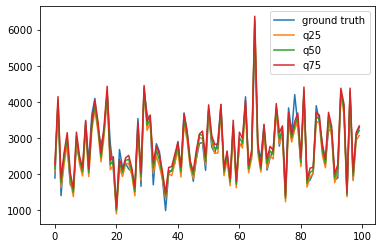

53.73095703125 234.2406960552601 382.04931640625 1.0


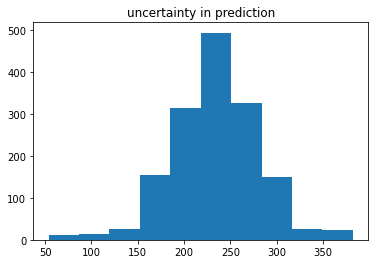

In [104]:
Dropout_model = 0.3856
FVC_weight = 0.2
Confidence_weight = 0
#!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
#!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(44)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
train = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/train.csv') 

tr_age_max = train.Age.values.max()
tr_age_min = train.Age.values.min()
tr_age_mean = train.Age.values.mean()

def expandFVC_Percent(DS):
    DS['FVC_Percent'] = DS['FVC'] / DS['Percent']
    return DS

def expandFE(data_set):
    data_set['MinWeeks'] = data_set.groupby('Patient')['Weeks'].transform('min')
    sub_tr = data_set.loc[data_set['Weeks']==data_set['MinWeeks']]

    sub_tr['MinFVC'] = sub_tr['FVC']

    sub_tr = sub_tr[['Patient', 'MinFVC']]

    merged = data_set.merge(sub_tr, on='Patient', how='outer')


    data_set=merged
    
    data_set['MinFVC'] = (data_set['MinFVC'] - data_set['MinFVC'].min())/(data_set['MinFVC'].max()-data_set['MinFVC'].min())
    print(data_set.sample(5))
    return data_set

train = expandFE(train)
# train = expandFVC_Percent(train)

print(train.head())
print(train.sample(10))

def get_tab(df):
    # df: data frame
    # [age, male/female[0/1], SmokingStatus[00/11/01], BaseFvc] (5,)
    vector = [(df.Age.values[0] - tr_age_min) / (tr_age_max-tr_age_min)] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    vector.extend([df['MinFVC'].values[0]])
#     vector.extend([df['FVC_Percent'].values[0]])
    return np.array(vector) 

A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

from tensorflow.keras.utils import Sequence
import math

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=8):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}  # imgs for each person; self.trian_data[pi] = [img1, img2, ..., imgn]
        for p in train.Patient.values:
            # filenames in "~/train/personid/"
            self.train_data[p] = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{p}/')
    
    def __len__(self):
#         return 1000
        return math.ceil(len(self.keys) / float(self.batch_size)) 
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)  # persons in batch size
        for k in keys:
            #  chose a {[img, tab], a}for each person (only 1 img)
            try:
                self.train_data[k].sort()
                mx_len = len(self.train_data[k])
                i = np.random.choice(self.train_data[k][mx_len//3:mx_len//3*2], size=1)[0]
#                 i = self.train_data[k][max_len//2]
                img = get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x, a, tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
#     inp2 = Input(shape=(4,))  # original is 4
    inp2 = Input(shape=(5,))  # add the feature of MinFVC
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(Dropout_model)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
#     weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
#     model.load_weights('../input/osic-model-weights/' + weights)
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
with strategy.scope():
    models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
    
print('Number of models: ' + str(len(models)))

model = models[0]

# model = get_model()

# efn_path = "../input/trainefn/efn.ckpt"
# model.load_weights(efn_path)

model.summary()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')  # original is lr=0.001

def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)
subs = []
q = -1

q = -1
# with open('../input/trainefn/q.txt', 'r') as f:
#     q=float(f.readlines()[0].strip())
print(q)

sub = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/sample_submission.csv') 
test = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv') 
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 

test = expandFE(test)
# test = expandFVC_Percent(test)

for p in test.Patient.unique():
    x = [] 
    tab = [] 
    ldir = os.listdir(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/')
    for i in ldir:
        if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
            x.append(get_img(f'/home/jacoblamkey/Documents/Data/.kaggle/test/{p}/{i}')) 
            tab.append(get_tab(test.loc[test.Patient == p, :])) 
    if len(x) <= 1:
        continue
    tab = np.array(tab) 

    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]


for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 

    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 

_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
subs.append(_sub)
print(subs)

N = len(subs)
print(N)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
print(img_sub.sample(5))

ROOT = "/home/jacoblamkey/Documents/Data/.kaggle"
BATCH_SIZE=128*strategy.num_replicas_in_sync

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
data['FVC_Percent'] = data['FVC'] / data['Percent']
# FE += ['age','percent','week','BASE', 'FVC_Percent']
FE += ['age','percent','week','BASE']
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss


def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model
print(FE)

y = tr['FVC'].values  # train target
z = tr[FE].values  # fetures (1535, 9)
print(z.shape)
ze = sub[FE].values  # fetures of submission (730, 9) e: estimate
print(ze.shape) 
nh = z.shape[1] 
print(nh)  # feature numbers (9,)
pe = np.zeros((ze.shape[0], 3))  #estimate of prediction
pred = np.zeros((z.shape[0], 3))  # prediction of truth ground
with strategy.scope():    
    net = make_model(nh)
print(net.summary())
print(net.count_params())
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

cnt = 0
EPOCHS = 800
y = y.astype(np.float32)
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()
sub.head()
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']
subm.head()
subm.describe().T
otest = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df = df1[['Patient_Week']].copy()
df['FVC'] = FVC_weight*df1['FVC'] + (1-FVC_weight)*df2['FVC']
df['Confidence'] = Confidence_weight*df1['Confidence'] + (1-Confidence_weight)*df2['Confidence']
df.head();
df.to_csv('submission.csv', index=False)

df_issa5 = df.copy()



# Save submission

In [159]:

df_issa1.to_csv('df_issa1.csv', index=False)
df_issa2.to_csv('df_issa2.csv', index=False)
df_issa3.to_csv('df_issa3.csv', index=False)
df_issa4.to_csv('df_issa4.csv', index=False)
df_issa5.to_csv('df_issa5.csv', index=False)

In [160]:
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg

In [178]:
df1Avg=cal_average(df_issa1.Confidence)
df2Avg=cal_average(df_issa2.Confidence)
df3Avg=cal_average(df_issa3.Confidence)
df4Avg=cal_average(df_issa4.Confidence)
df5Avg=cal_average(df_issa5.Confidence)
print(df1Avg,df2Avg,df3Avg,df4Avg,df5Avg)

df1Avg=cal_average(df_issa1.FVC)
df2Avg=cal_average(df_issa2.FVC)
df3Avg=cal_average(df_issa3.FVC)
df4Avg=cal_average(df_issa4.FVC)
df5Avg=cal_average(df_issa5.FVC)

print(df1Avg,df2Avg,df3Avg,df4Avg,df5Avg)

285.1376706156206 277.8478653999224 275.6832930891481 283.53341286019105 274.3653726656143
2643.7117066487094 2674.0927686860355 2682.562560441635 2685.66590556549 2679.966320337359


In [208]:
otest = pd.read_csv('/home/jacoblamkey/Documents/Data/.kaggle/test.csv')
otest['Patient_Week'] = otest['Patient'].map(str) + "_" + otest['Weeks'].map(str)
otest.head()
test_avg = cal_average(otest.FVC)

In [207]:
resultFvc = []
resultCon = []
an=[]
bn=[]
cn=[]
dn=[]
en=[]


    
for a in np.arange(0, 1.1, 0.05):
    for b in np.arange(0, 1.1, 0.05):
        for c in np.arange(0, 1.1, 0.05):
            for d in np.arange(0, 1.1, 0.05):
                for e in np.arange(0, 1.1, 0.05):
                    if((a + b + c + d + e) == 1):
                        df = df_issa1[['Patient_Week']].copy()
                        df['FVC'] =  a * df_issa1['FVC'] +  b * df_issa2['FVC'] +  c * df_issa3['FVC'] + d * df_issa4['FVC'] +  e * df_issa5['FVC']

                        df['Confidence'] = a * df_issa1['Confidence'] +   b * df_issa2['Confidence'] +  c * df_issa3['Confidence'] +d * df_issa4['Confidence'] + e * df_issa5['Confidence']

                       #test_score = pd.merge(otest,df, on = 'Patient_Week',how="left")
                        #sigma_opt = mean_absolute_error(y, pred[:, 1])
                        #score = score(test_score.FVC, test_score.FVC1)
                        
                        dfConAvg=cal_average(df.Confidence)
                        dfFvcAvg=cal_average(df.FVC)
                        resultCon.append(dfConAvg)
                        resultFvc.append(dfFvcAvg)
                        #sigma_optn.append(sigma_opt)
                        #scoren.append(score)
                        an.append(a)
                        bn.append(b)
                        cn.append(c)
                        dn.append(d)
                        en.append(e)
                        del(dfConAvg,dfFvcAvg,a,b,c,d,e,df)

NameError: name 'rm' is not defined

In [183]:
conf_list = [resultCon,an,bn,cn,dn,en]
fvc_list = [resultFvc,an,bn,cn,dn,en]

Confidence = pd.DataFrame(conf_list).transpose()
Confidence.columns = ['confidenceEnsemble','a','b','c','d','e']
fvc = pd.DataFrame(fvc_list).transpose()
fvc.columns = ['fvcEnsemble','a','b','c','d','e']

confidence_min = Confidence.sort_values('confidenceEnsemble').iloc[[0]]
fvc_min = fvc.sort_values('fvcEnsemble').iloc[[0]]


In [216]:
print("Dataframe Contens ", confidence_min, sep='\n')
print("Dataframe Contens ", fvc_min, sep='\n')

print(df1Avg)
print(df2Avg)
print(df3Avg)
print(df4Avg)
print(df5Avg)

print(test_avg)
fvc.to_csv('fvc.csv', index=False)

Dataframe Contens 
   confidenceEnsemble    a    b    c    d    e
0          274.365373  0.0  0.0  0.0  0.0  1.0
Dataframe Contens 
      fvcEnsemble    a    b    c    d    e
5083  2643.711707  1.0  0.0  0.0  0.0  0.0
2643.7117066487094
2674.0927686860355
2682.562560441635
2685.66590556549
2679.966320337359
2781.6


In [174]:
a= confidence_min.iloc[0]['a']
b= confidence_min.iloc[0]['b']
c= confidence_min.iloc[0]['c']
d= confidence_min.iloc[0]['d']
e= confidence_min.iloc[0]['e']

print(a)
print(b)
print(c)
print(d)
print(e)


0.0
0.0
0.0
0.0
1.0


In [217]:
a = .15
b = .25
c = .15
d = .2
e = .25
df = df_issa1.copy()
df['FVC'] = a*df_issa1['FVC'] + b*df_issa2['FVC'] + c*df_issa3['FVC'] + d*df_issa4['FVC'] +e*df_issa5['FVC']
            
df['Confidence'] = a*df_issa1['Confidence'] + b*df_issa2['Confidence'] +  c*df_issa3['Confidence'] +  d*df_issa4['Confidence'] +e*df_issa5['Confidence']
df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2884.679778,247.979191
1,ID00419637202311204720264_-10,2902.870292,240.401272
2,ID00419637202311204720264_-11,2904.946964,239.567416
3,ID00419637202311204720264_-12,2907.024109,238.733437
4,ID00419637202311204720264_-2,2886.637641,247.135683


In [177]:
df.to_csv('submission.csv', index=False)